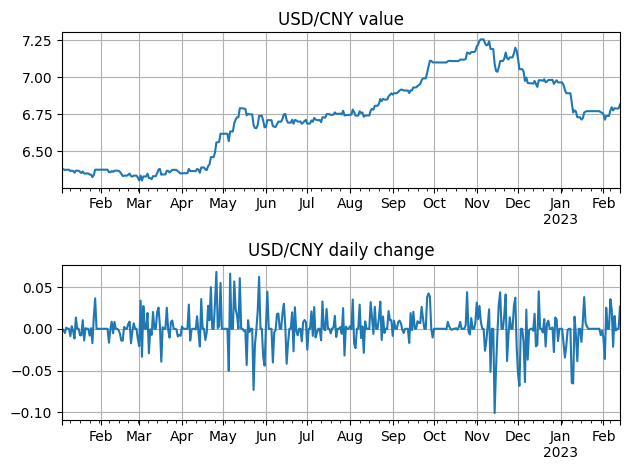

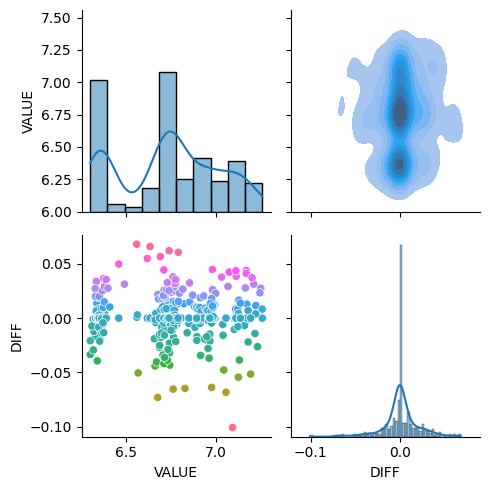

In [11]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates
import matplotlib.ticker as mtick

import seaborn as sns

import ConnectSQLdb
from ConnectSQLdb import config

import warnings
warnings.filterwarnings('ignore')

engine = create_engine(f"mysql+pymysql://{config['user']}:{config['password']}@{config['host']}/{config['database']}", echo=False)

# Get data for USD/CNY 
sql = ("SELECT DATE, NOMINAL, VALUE FROM currencies "
       "WHERE SOURCE = 'CFETS' AND CURRENCY = 'USD/CNY';")
df1 = pd.read_sql(sql, con=engine)

# Reindex data filling in missing dates (holidays and weekends)
idx = pd.date_range(min(df1.DATE), max(df1.DATE))
df1 = df1.set_index("DATE")
df1 = df1.reindex(idx)
df1 = df1.fillna(method='ffill')

# Add column with daily change values
df1['DIFF'] = df1.VALUE - df1.VALUE.shift(1)
df1.DIFF = df1.DIFF.fillna(0)

# Plot data
plt.rcParams["figure.autolayout"] = True
fig, axes = plt.subplots(2,1)
df1.drop("NOMINAL", axis=1).VALUE.plot(ax=axes[0], grid=True, title='USD/CNY value')
df1.drop("NOMINAL", axis=1).DIFF.plot(ax=axes[1], grid=True, title='USD/CNY daily change')

# Plot distributions
g = sns.PairGrid(df1.drop("NOMINAL", axis=1))
g.map_diag(sns.histplot, kde=True)
g.map_upper(sns.kdeplot, fill=True)
g.map_lower(sns.scatterplot, hue=df1.DIFF, palette='husl');

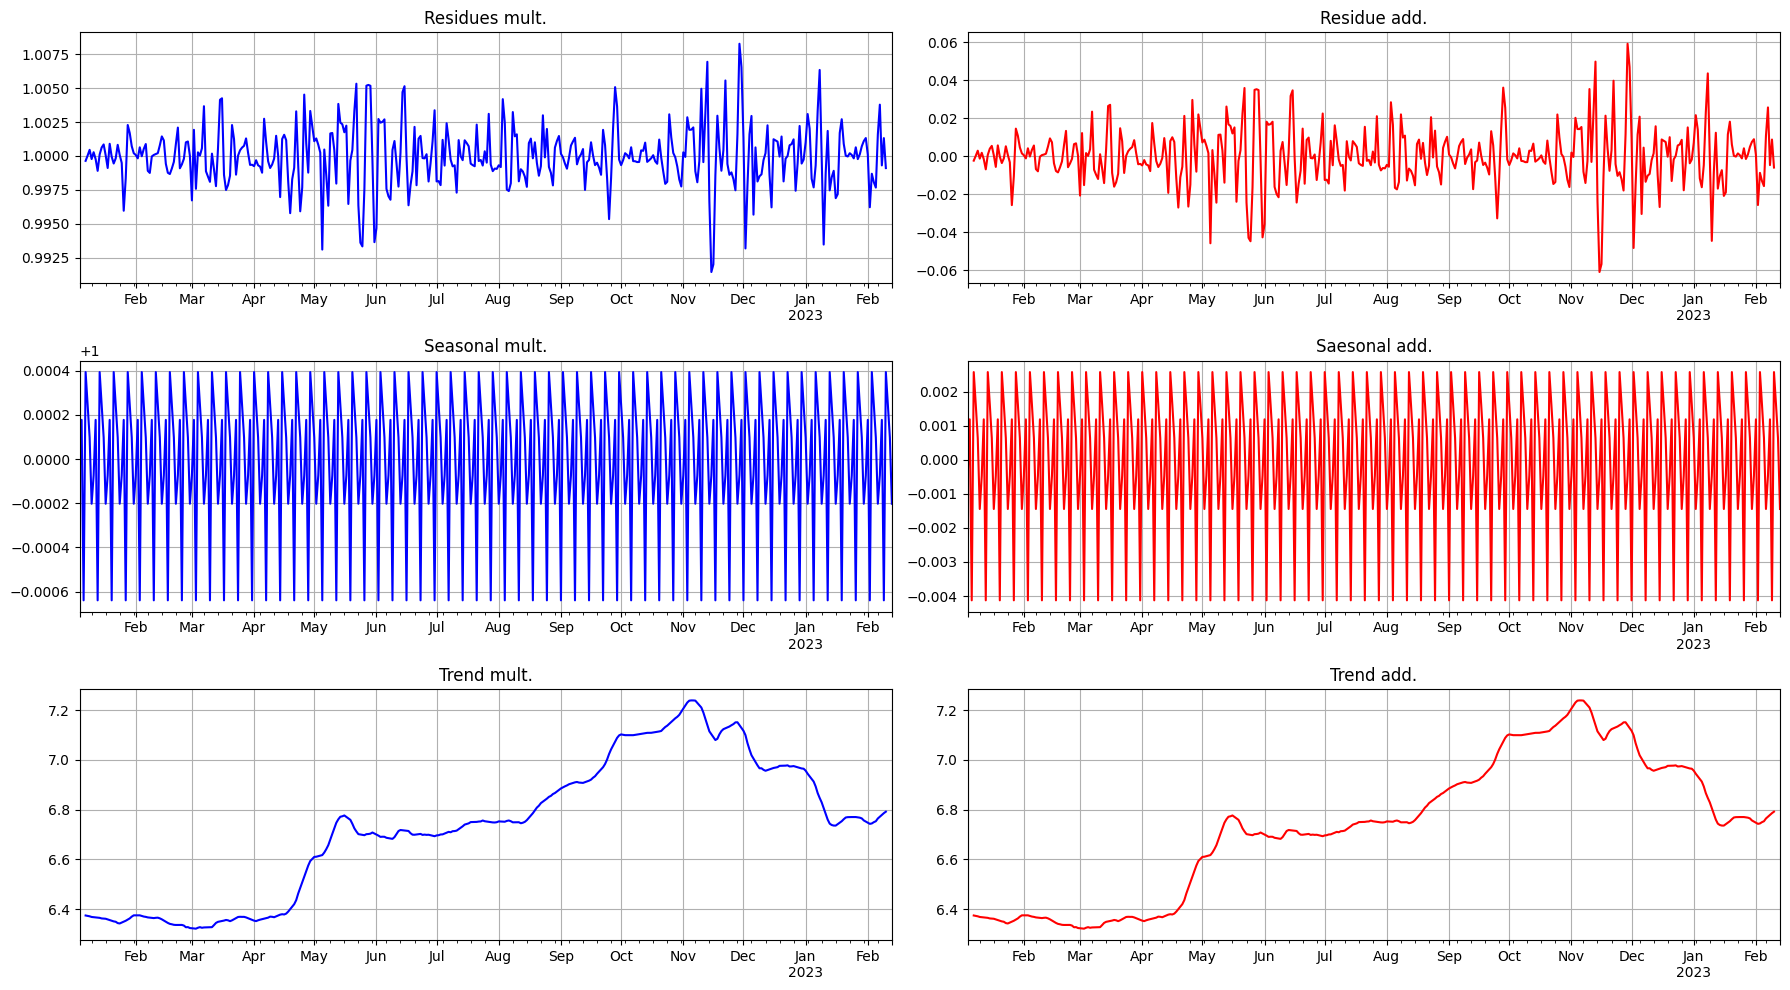

In [12]:
# Perform seasonal decompose
from statsmodels.tsa.seasonal import seasonal_decompose
result_add = seasonal_decompose(df1.VALUE,model = 'add')
result_mul = seasonal_decompose(df1.VALUE,model = 'mul')

# Plot results
fig, axes = plt.subplots(3,2)
fig.set_size_inches(18,10)
resid_mul = result_mul.resid
seasonal_mul = result_mul.seasonal
trend_mul = result_mul.trend
resid_mul.plot(color='blue', ax=axes[0,0], title='Residues mult.', grid=True)
seasonal_mul.plot(color='blue', ax=axes[1,0], title='Seasonal mult.', grid=True)
trend_mul.plot(color='blue', ax=axes[2,0], title='Trend mult.', grid=True);
resid_add = result_add.resid
seasonal_add = result_add.seasonal
trend_add = result_add.trend
resid_add.plot(color='red', ax=axes[0,1], title='Residue add.', grid=True)
seasonal_add.plot(color='red', ax=axes[1,1], title='Saesonal add.', grid=True)
trend_add.plot(color='red', ax=axes[2,1], title='Trend add.', grid=True);

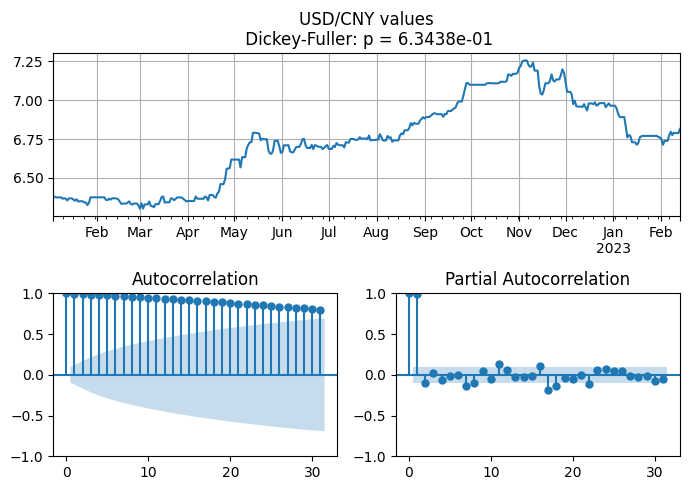

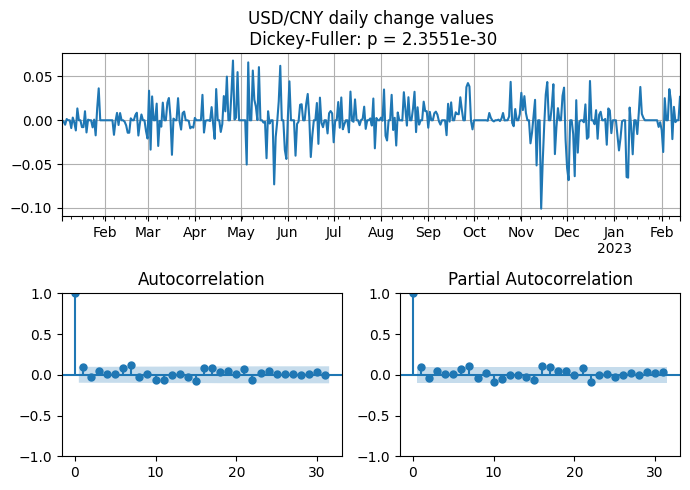

In [13]:
# Perform Dickey-Fuller test and compute auto-correlation and partial auto-correl.
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller

# Plot results
def plot_correl(series, name):
    p_value = sm.tsa.stattools.adfuller(series)

    fig, axes = plt.subplot_mosaic([['A', 'A'], ['B', 'C']])
    fig.set_size_inches(7,5)
    series.plot(ax=axes['A'], title=f"{name} values\n Dickey-Fuller: p = {p_value[1]:0.4e}", grid=True);
    smt.graphics.plot_acf(series, lags=31, ax=axes['B']);
    smt.graphics.plot_pacf(series, lags=31, ax=axes['C']);
plot_correl(df1.VALUE, 'USD/CNY')
plot_correl(df1.DIFF, 'USD/CNY daily change')

100%|██████████| 81/81 [01:46<00:00,  1.32s/it]


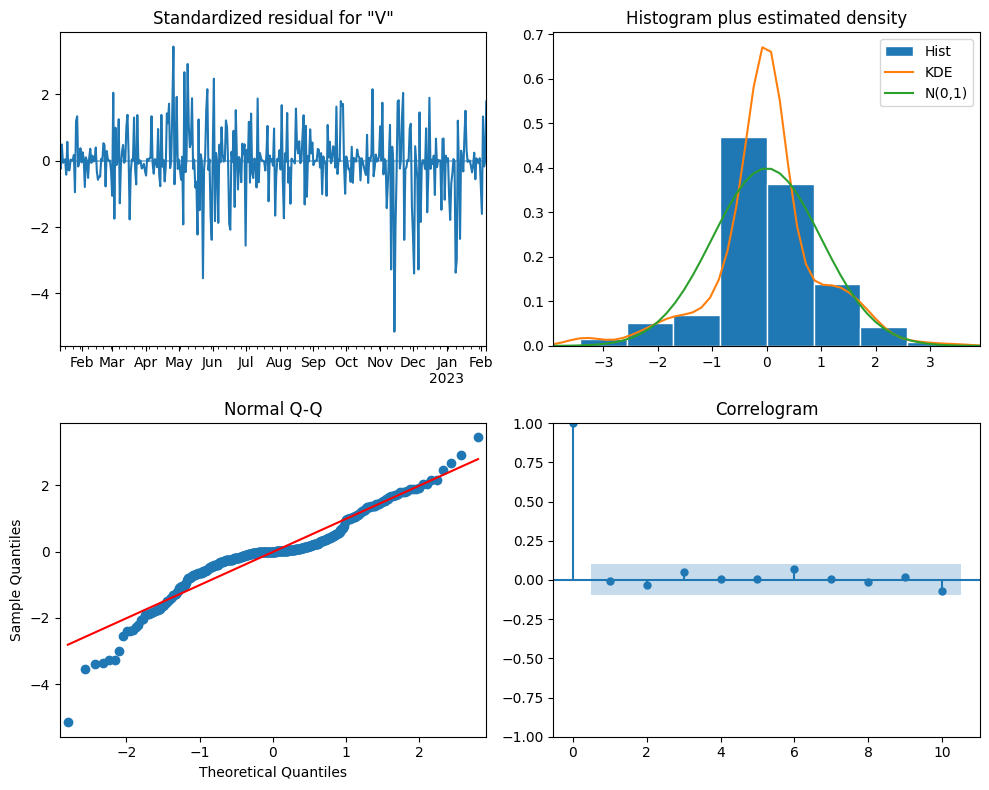

In [14]:
# Build list of parameters for choise of model 
from itertools import product
import statsmodels.api as sm
from tqdm import tqdm

ps = range(0, 3)
d = 1
qs = range(0, 3)
Ps = range(0, 3)
D = 1
Qs = range(0, 3)
s = 7
params = list(product(ps, qs, Ps, Qs))

# Split data for model assessment
train = df1[:int(len(df1)-7)]
test = df1[-7: ]

# Choose the best model based on AIC value
best_aic=float('inf')
for case in tqdm(params):
    p = case[0]
    d = 1
    q = case[1]
    P = case[2]
    Q = case[3]
    s = 7
    try: 
        model =  sm.tsa.SARIMAX(
            endog=train.VALUE, 
            order=(p,d,q),
            seasonal_order=(P,D,Q,s)
        ).fit()
    except:
        continue
    if model.aic < best_aic:
        best_aic = model.aic
        best_model = model
        best_param = case

# Plot results
best_model.plot_diagnostics(figsize=(10,8));

In [16]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                  VALUE   No. Observations:                  399
Model:             SARIMAX(0, 1, 1)x(1, 1, [1, 2], 7)   Log Likelihood                 976.709
Date:                                Tue, 14 Feb 2023   AIC                          -1943.418
Time:                                        18:10:43   BIC                          -1923.575
Sample:                                    01-04-2022   HQIC                         -1935.553
                                         - 02-06-2023                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1290      0.040      3.198      0.001       0.050       0.208
ar.S.L7       -0.7488      0.106     -7.092      0.000      -0.956      -0.542
ma.S.L7       -0.1319      0.096     -1.374      0.169      -0.320       0.056
ma.S.L14      -0.8406      0.086     -9.793      0.000      -1.009      -0.672
sigma2         0.0004   2.02e-05     18.472      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               207.00
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               1.75   Skew:                            -0.65
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

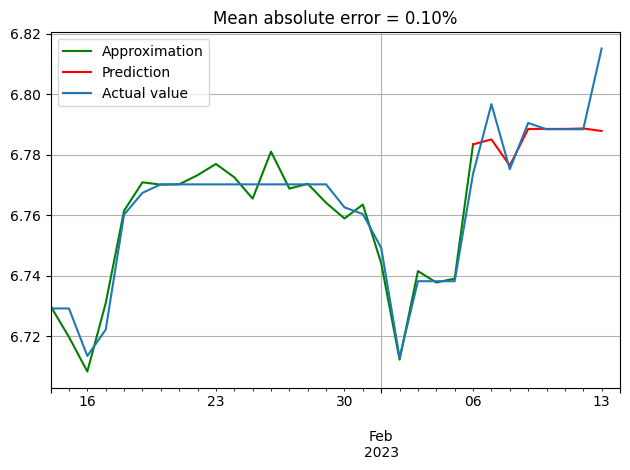

In [15]:
# A\Perform forecast and assess prediction
def mse_p(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))

y_approx = best_model.predict(len(df1)-31, len(df1)-7).shift(-1)
y_approx.plot(color='green')
y_pred = best_model.predict(len(df1)-8, len(df1)).shift(-1)
y_pred.plot(color='red')
df1.VALUE[-31:].plot()
plt.legend(['Approximation','Prediction', 'Actual value']);
plt.grid()
plt.title(f"Mean absolute error = {mse_p(df1.VALUE[-8:],y_pred):0.2%}");